In [1]:
import numpy as np 
import scipy.stats as sp 
import matplotlib.pyplot as plt 

In [72]:
def heartbeats(sd_alpha, sd_delta, sd_hyperparam, nchain, hearts_data):
    #2 parameters to estimate 
    chain = np.zeros((nchain+1, 2)) #alpha and delta 
    #init at 0,0 (told so in the data folder) --> p = 0.5 and theta = 0.5
    #rate of acceptance 
    acceptance = 0
    
    #data
    t = hearts_data[:, 0]
    x = hearts_data[:, 1]
    y = hearts_data[:, 2]
    
    #density 
    def log_g(alpha, delta, t, x, y,sigma, tau):
        #vector that indicates the value where the is no PVC's
        idx0 = np.where(y ==0)
        idx1 = np.where(y !=0)
        y0 = y[idx0] #vecteur sans PVC's
        y1 = y[idx1]
        x1 = y[idx1]
        t0 = t[idx0]
        t1 = t[idx1]
        n0 = y0.sum() 
        n1 = (y1).sum()
        
        sum1 = -((alpha/sigma)**2 + (delta/tau)**2)/2
        sum2 = n1 * np.log(1+np.exp(delta)) - np.log(1+np.exp(-alpha)) * y1.sum() - np.log(1+np.exp(alpha)) * x1.sum()
        sum3 = (np.log( (1+np.exp(-delta))**(-1) + (1+np.exp(alpha))**(-t0) * (1+np.exp(delta))**(-1))).sum()

        return sum1 +sum2+sum3
    
    for i in range(nchain):
        index = np.random.choice([0,1])
        chain[i+1, :] = chain[i,:]
        chain[i+1, index] = chain[i, index] + np.random.normal(scale = np.sqrt(sd_hyperparam[index])) #changement d'une seule coord
        #print(new_candidate)
        #proposal kernel symetric --> only the difference between the log-densities 
        ratio = log_g(chain[i+1, 0], chain[i+1, 1], t, x, y, sd_hyperparam[0], sd_hyperparam[1]) - \
            log_g(chain[i,0], chain[i, 1], t, x, y, sd_hyperparam[0], sd_hyperparam[1])
        #print(ratio)
        #MAJ 
        u = np.log(np.random.uniform())
        if u < ratio: 
            acceptance += 1
        else:
            chain[i+1, :] = chain[i, :]
        
        
        #using the inverse of logit to get p and theta ? 
        
    return chain, acceptance/nchain

In [73]:
#number of individual 
N = 12
#PVC total count 
t = np.array([11, 11, 17, 22, 9, 6, 5, 14, 9, 7, 22, 51])

#before drugs 
x = np.array([6, 9, 17, 22, 7, 5, 5, 14, 9, 7, 9, 51])

#after drugs 
y = np.array([5, 2, 0, 0, 2, 1, 0, 0, 0, 0, 13, 0])

heats = np.vstack((t,x,y))
hearts = heats.T
hearts

array([[11,  6,  5],
       [11,  9,  2],
       [17, 17,  0],
       [22, 22,  0],
       [ 9,  7,  2],
       [ 6,  5,  1],
       [ 5,  5,  0],
       [14, 14,  0],
       [ 9,  9,  0],
       [ 7,  7,  0],
       [22,  9, 13],
       [51, 51,  0]])

In [110]:
hyperparam = np.array([1/10, 1/10])
chain, accep = heartbeats(.1, 1, hyperparam, 11000, heats)

In [111]:
print(accep)

0.3512727272727273


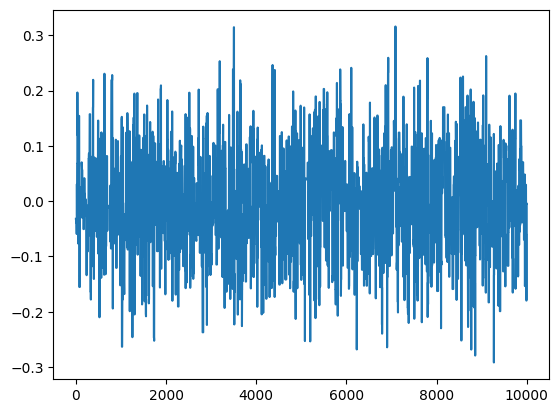

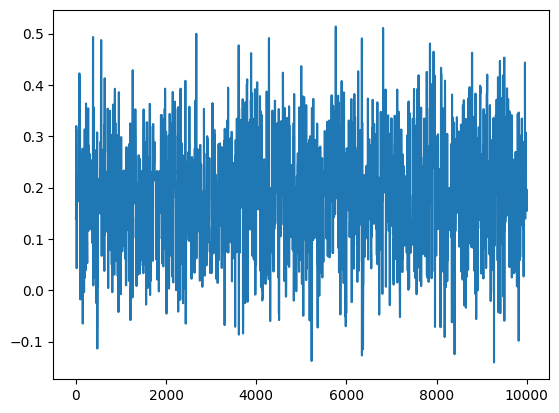

In [112]:
plt.plot(chain[1000:, 0])
plt.show()
plt.plot(chain[1000:, 1])
plt.show()

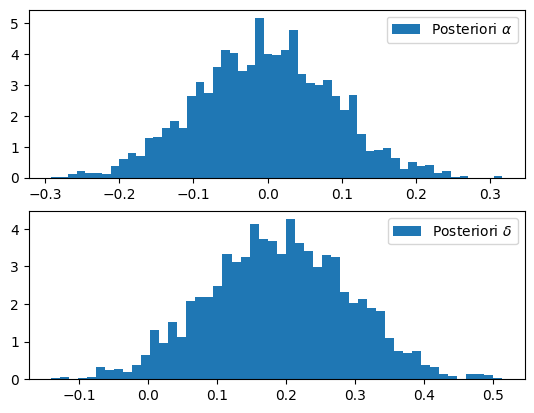

In [113]:
#proprièté des estimation 

alpha = chain[:, 0]
delta = chain[:, 1]

fig, ax = plt.subplot_mosaic([["A", "A"],
                              ["B", "B"]])
ax["A"].hist(alpha[1000:], bins= 'auto', label= r"Posteriori $\alpha$", density = True);
ax["A"].legend()
ax["B"].hist(delta[1000:], bins= 'auto', label= r"Posteriori $\delta$", density = True);
ax["B"].legend()

In [114]:
print(f"La valeur moyenne de alpha {alpha[1000:].mean()} et son ecart-type {alpha[1000:].std()}")
print(f"La valeur moyenne de alpha {delta[1000:].mean()} et son ecart-type {delta[1000:].std()}")

La valeur moyenne de alpha -0.0041013639182680564 et son ecart-type 0.09114653555014628
La valeur moyenne de alpha 0.18961812273972817 et son ecart-type 0.10222915104007736


In [118]:
estimate_p = (1/(1+ np.exp(alpha[1000:]))).mean()
estimate_p
estimate_theta = (1/(1+ np.exp(delta[1000:]))).mean()
estimate_theta


0.45285861979012